In [2]:
import os
import tempfile
#import torch
#from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
#from torchgeo.datasets import RasterDataset, stack_samples, unbind_samples
#from torchgeo.datasets.utils import download_url
#from torchgeo.samplers import RandomGeoSampler, GridGeoSampler
import rasterio
import re
import shutil

# Data cleaning

## Folder cleaning
- Some folders were created but just contain previous dates. Does this for 2015-mid 2017 for Sentinel 2
- Some folders could be incomplete
- Some files are not needed
    - `ARVI`
    - `SAVI`
    - `stderr.log`
    - `stdout.log`
    - `output.info`
    - `policy`
    - `data_acknowledgement`

#### Delete unnecessary files
Uncomment line to actually delete files

In [4]:
data_path = 'downloads/SENTINEL 2/'
to_del = ['ARVI', 'SAVI', 'stderr', 'stdout', 'policy', 'output', 'data_acknowledgement']
for folder in os.listdir(data_path):
    for file in os.listdir(data_path+folder):
        if any(substring in file for substring in to_del):
            os.remove(data_path + folder + '/' +   file)
           #print(data_path + folder + '/' + file)

#### Folders with wrong dates

In [7]:
# See which folders have different folder and file dates

data_path = 'downloads/SENTINEL 2/'
for folder in os.listdir(data_path):
    folder_date = folder.split('T')[0]
    for file in os.listdir(data_path+folder):
        if file.startswith('High'):
            date_match = re.search('\d{2}_\d{2}_\d{4}', file).group()
            file_date = date_match[-4:] + '-' + date_match[-10:-8] + '-' +  date_match[-7:-5]
            break
    if folder_date != file_date:
        print('No match!\nFolder date:', folder_date, '\nFile date:', file_date)

In [6]:
# Remove which folders have different folder and file dates

data_path = 'downloads/SENTINEL 2/'
for folder in os.listdir(data_path):
    folder_date = folder.split('T')[0]
    for file in os.listdir(data_path+folder):
        if file.startswith('High'):
            date_match = re.search('\d{2}_\d{2}_\d{4}', file).group()
            file_date = date_match[-4:] + '-' + date_match[-10:-8] + '-' +  date_match[-7:-5]
            break
    if folder_date != file_date:
        shutil.rmtree(data_path+folder)

#### Incomplete folders: careful! Could be Cloud Probability 

In [8]:
data_path = 'downloads/SENTINEL 2/'
for folder in os.listdir(data_path):
    filelist = [file for file in os.listdir(data_path+folder) if file.endswith('.tiff')]
    if len(filelist)<10:
        print(folder)

2020-06-30T00:00:00Z_46.907_7.137_47.407_7.637
2020-07-11T00:00:00Z_46.907_7.137_47.407_7.637
2020-05-11T00:00:00Z_46.907_7.137_47.407_7.637
2020-03-07T00:00:00Z_46.907_7.137_47.407_7.637
2020-11-02T00:00:00Z_46.907_7.137_47.407_7.637
2020-09-23T00:00:00Z_46.907_7.137_47.407_7.637
2020-11-17T00:00:00Z_46.907_7.137_47.407_7.637
2020-11-08T00:00:00Z_46.907_7.137_47.407_7.637
2020-03-23T00:00:00Z_46.907_7.137_47.407_7.637
2020-07-20T00:00:00Z_46.907_7.137_47.407_7.637
2020-11-22T00:00:00Z_46.907_7.137_47.407_7.637
2020-05-27T00:00:00Z_46.907_7.137_47.407_7.637
2020-03-03T00:00:00Z_46.907_7.137_47.407_7.637
2020-09-03T00:00:00Z_46.907_7.137_47.407_7.637
2020-08-25T00:00:00Z_46.907_7.137_47.407_7.637
2021-11-23T00:00:00Z_46.907_7.137_47.407_7.637
2020-03-22T00:00:00Z_46.907_7.137_47.407_7.637
2020-09-28T00:00:00Z_46.907_7.137_47.407_7.637
2020-05-07T00:00:00Z_46.907_7.137_47.407_7.637
2019-09-15T00:00:00Z_46.907_7.137_47.407_7.637
2020-05-17T00:00:00Z_46.907_7.137_47.407_7.637
2020-04-26T00

## Name cleaning
Simplify and hogmogenise the filenamesto facilitate procssind downstream

In [2]:
def clean_filenames(dir_path, datasource):
    """
    Rename files to keep only band name and date
    Delete other files
    parameters
    --------
    inputs
    dir_path: str
        path to folder of files that need to be cleaned
    datasource: str
        one of ['era', 'sen', 'lc', 'nasa']
    """
    
    if datasource in ['era', 'sen']:
       
        for folder in os.listdir(dir_path):
            if folder.startswith('2'): #date
                datetime = folder.split('Z')[0]
                for f in os.listdir(dir_path + folder):
                    if f.endswith('.tiff'):
                        band_name = f.split('[')[1].split(']')[0]
                        new_name = band_name + '_' + datetime + '.tiff'
                        os.rename(dir_path + folder + '/' + f, dir_path + folder + '/' + new_name)
                        # delete all other files?
                        
    if datasource in ['lc']:
       
        for folder in os.listdir(dir_path):
            if folder.startswith('2'): #date
                datetime = folder.split('_')[0]
                for f in os.listdir(dir_path + folder):
                    if f.endswith('.tiff'):
                        new_name = 'LCv3_' + datetime + '.tiff'
                        os.rename(dir_path + folder + '/' + f, dir_path + folder + '/' + new_name)
                        # delete all other files?

    if datasource in ['nasa']:
       
        for folder in os.listdir(dir_path):
            if folder.startswith('4'): #coordinate
                for f in os.listdir(dir_path + folder):
                    if f.endswith('.tiff'):
                        new_name = 'nasadem.tiff'
                        os.rename(dir_path + folder + '/' + f, dir_path + folder + '/' + new_name)
                        # delete all other files?

In [3]:
sen_path = '/Users/emi/Documents/GitHub/Drought_Impact/Data Downloading/downloads/SENTINEL 2/'
era_path = '/Users/emi/Documents/GitHub/Drought_Impact/Data Downloading/downloads/ERA5/'
lc_path = '/Users/emi/Documents/GitHub/Drought_Impact/Data Downloading/downloads/LC Copernicus/'
nasa_path = '/Users/emi/Documents/GitHub/Drought_Impact/Data Downloading/downloads/NASA DEM/'

#clean_filenames(sen_path, 'sen')
#clean_filenames(era_path, 'era')
clean_filenames(lc_path, 'lc')
clean_filenames(nasa_path, 'nasa')

# TorchGeo data sampler and loader

## Create dataset 

In [4]:
class Sentinel2(RasterDataset):
    filename_glob = "*.tiff"
    filename_regex = r"^2*" 
    date_format = "%Y%m%dT%H%M%S"
    is_image = True
    separate_files = True
    all_bands = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8a", "B11", "B12", "NDVI", "SCL", "CP"] 
    rgb_bands = ["B04", "B03", "B02"]
    
    def plot(self, sample):
        # Find the correct band index order
        rgb_indices = []
        for band in self.rgb_bands:
            rgb_indices.append(self.all_bands.index(band))

        # Reorder and rescale the image
        image = sample["image"][rgb_indices].permute(1, 2, 0)
        image = torch.clamp(image / 6000, min=0, max=1).numpy()

        # Plot the image
        fig, ax = plt.subplots()
        ax.imshow(image)

        return fig

In [5]:
SenDataset = Sentinel2(sen_path)

In [6]:
print(SenDataset)

Sentinel2 Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=6.8984319999999855, maxx=7.951103999999987, miny=47.099264, maxy=47.150464, mint=0.0, maxt=9.223372036854776e+18)
    size: 19


In [ ]:
torch.manual_seed(1)

dataset = Sentinel2(sen_path)
sampler = RandomGeoSampler(dataset, size=256, length=1)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)

for batch in dataloader:
    sample = unbind_samples(batch)[0]
    dataset.plot(sample)
    plt.axis("off")
    plt.show()

In [7]:
class NasaDEM(RasterDataset):
    filename_glob = "*.tiff"
    filename_regex = r"^nasadem*" 
    date_format = "%Y%m%dT%H%M%S"
    is_image = True
    separate_files = True
    all_bands = ["DEM"]
    
    def plot(self, sample):
        # Find the correct band index order
        indices = []
        for band in self.all_bands:
            indices.append(self.all_bands.index(band))

        # Reorder and rescale the image
        image = sample["image"][indices].permute(1, 2, 0)
        image = torch.clamp(image / 6000, min=0, max=1).numpy()

        # Plot the image
        fig, ax = plt.subplots()
        ax.imshow(image)

        return fig

In [8]:
dataset = NasaDEM(nasa_path)
print(dataset)

NasaDEM Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=7.135999999999996, maxx=7.637759999999995, miny=46.906752000000004, maxy=47.408512, mint=0.0, maxt=9.223372036854776e+18)
    size: 1


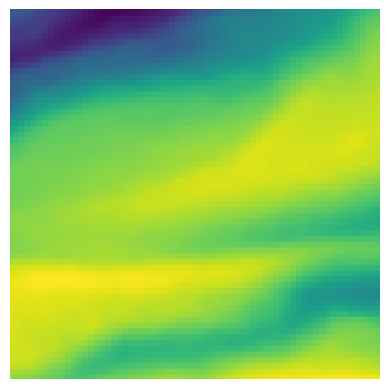

In [9]:
torch.manual_seed(1)

dataset = NasaDEM(nasa_path)
sampler = RandomGeoSampler(dataset, size=256, length=1)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)

for batch in dataloader:
    sample = unbind_samples(batch)[0]
    dataset.plot(sample)
    plt.axis("off")
    plt.show()

In [10]:
class LCCopernicus(RasterDataset):
    filename_glob = "*.tiff"
    filename_regex = r"^2*" 
    date_format = "%Y%m%dT%H%M%S"
    is_image = True
    separate_files = True
    all_bands = ["LC"]
    
    def plot(self, sample):
        # Find the correct band index order
        indices = []
        for band in self.all_bands:
            indices.append(self.all_bands.index(band))

        # Reorder and rescale the image
        image = sample["image"][indices].permute(1, 2, 0)
        image = torch.clamp(image / 6000, min=0, max=1).numpy()

        # Plot the image
        fig, ax = plt.subplots()
        ax.imshow(image)

        return fig

In [11]:
dataset = LCCopernicus(lc_path)
print(dataset)

LCCopernicus Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=7.135999999999996, maxx=7.637759999999995, miny=46.906752000000004, maxy=47.408512, mint=0.0, maxt=9.223372036854776e+18)
    size: 4


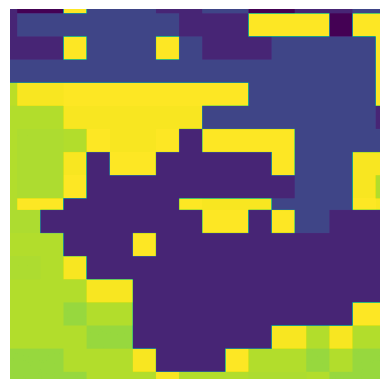

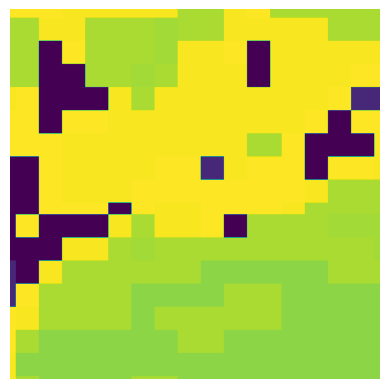

In [12]:
torch.manual_seed(1)

dataset = LCCopernicus(lc_path)
sampler = RandomGeoSampler(dataset, size=256, length=2)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)

for batch in dataloader:
    sample = unbind_samples(batch)[0]
    dataset.plot(sample)
    plt.axis("off")
    plt.show()

In [13]:
class ERA5(RasterDataset):
    filename_glob = "*.tiff"
    filename_regex = r"^2*" 
    date_format = "%Y%m%dT%H%M%S"
    is_image = True
    separate_files = True
    all_bands = ["Red","Total Prec","SP","Temp","AWVC","SR","TCC","MinT","MaxT"]
    
    def plot(self, sample):
        # Find the correct band index order
        indices = []
        for band in self.all_bands:
            indices.append(self.all_bands.index(band))

        # Reorder and rescale the image
        image = sample["image"][indices].permute(1, 2, 0)
        image = torch.clamp(image / 6000, min=0, max=1).numpy()

        # Plot the image
        fig, ax = plt.subplots()
        ax.imshow(image)

        return fig

In [14]:
dataset = ERA5(era_path)
print(dataset)

ERA5 Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=6.8984319999999855, maxx=7.951103999999987, miny=47.099264, maxy=47.150464, mint=0.0, maxt=9.223372036854776e+18)
    size: 10


In [ ]:
torch.manual_seed(1)

dataset = ERA5(era_path)
sampler = RandomGeoSampler(dataset, size=256, length = 1)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)

for batch in dataloader:
    sample = unbind_samples(batch)[0]
    dataset.plot(sample)
    plt.axis("off")
    plt.show()